In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieu\KinhTeViMo\cpi.csv')

In [5]:
data.head()

,tg,t,cpi
0,0,Jan-95,103.8
1,1,Feb-95,103.4
2,2,Mar-95,100.2
3,3,Apr-95,101.0
4,4,May-95,101.8


In [7]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieu\KinhTeViMo\cpi.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[1]))
    close.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Năm', ylabel='CPI')

ValueError: invalid literal for int() with base 10: 'Jan-95'

In [20]:
# Define the split time
split_time = int(0.8*len(series))

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [22]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [23]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time
start_time=time.time()
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
tg=time.time() - start_time
print('Thời gian huấn luyện', tg)

Epoch 1/100


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

(1e-08, 0.001, 0.0, 100.0)

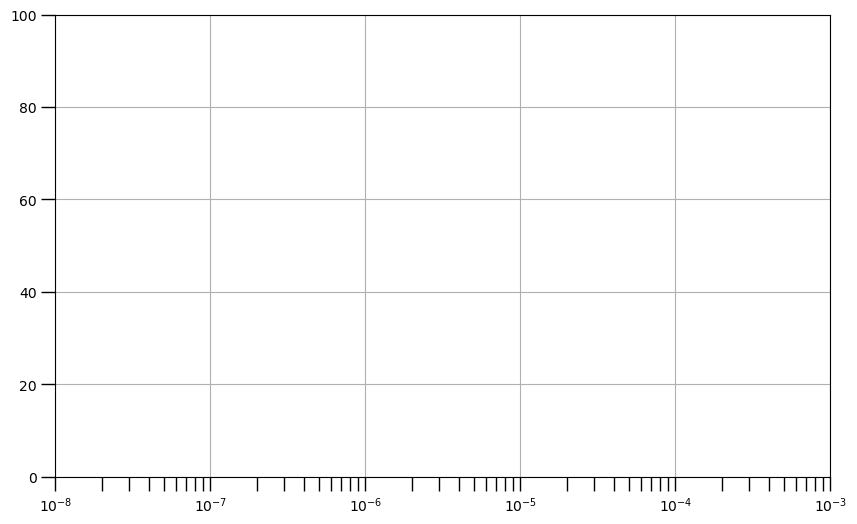

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


In [13]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [14]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 22533.4785 - mse: 508456160.0000
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 134519.7812 - mse: 18199818240.0000
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 50326.8945 - mse: 2535863552.0000
Epoch 4/100
1/1 [==============================] - 0s 57ms/step - loss: 22799.0352 - mse: 520040672.0000
Epoch 5/100
1/1 [==============================] - 0s 56ms/step - loss: 22799.0352 - mse: 520040672.0000
Epoch 6/100
1/1 [==============================] - 0s 79ms/step - loss: 22799.0352 - mse: 520040672.0000
Epoch 7/100
1/1 [==============================] - 0s 52ms/step - loss: 22799.0352 - mse: 520040672.0000
Epoch 8/100
1/1 [==============================] - 0s 45ms/step - loss: 22799.0352 - mse: 520040672.0000
Epoch 9/100
1/1 [==============================] - 0s 59ms/step - loss: 22799.0332 - mse: 520040672.0000
Epoch 10/100
1/1 [==============================] - 0

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [16]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
import numpy as np

def mean_squared_error(actual, predicted):
    return np.mean((actual - predicted) ** 2)

# Tính MSE
mse = mean_squared_error(x_valid, results)
print("Mean Squared Error (MSE):", mse)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu CPI
data = pd.read_csv('D:\DeTaiNam2024\SoLieu\KinhTeViMo\gdp.csv')  # Thay 'path_to_cpi_data.csv' bằng đường dẫn của bạn
data = data['GDP_VN'].values  # Giả sử cột CPI chứa chỉ số cần dự báo
data = data.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Tạo chuỗi thời gian
sequence_length = 12  # Ví dụ dùng 12 tháng để dự báo tháng tiếp theo
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i, 0])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Chia tập huấn luyện và kiểm tra
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, RNN

class sLSTMCell(LSTMCell):
    def __init__(self, units, **kwargs):
        super(sLSTMCell, self).__init__(units, **kwargs)
    
    def call(self, inputs, states, training=None):
        # Gọi hàm LSTM mặc định
        h, [c, h] = super(sLSTMCell, self).call(inputs, states, training=training)
        
        # Tùy chỉnh cổng quên và cổng đầu vào
        forget_gate = tf.math.exp(c)  # Sử dụng hàm mũ e cho cổng quên
        input_gate = tf.math.exp(2 * c)  # Sử dụng hàm mũ cơ số 2 cho cổng đầu vào
        
        # Áp dụng các cổng vào trạng thái bộ nhớ
        new_c = forget_gate * c + input_gate * h
        
        # Trả về trạng thái cập nhật và output
        return h, [new_c, h]

# Tạo lớp RNN với sLSTMCell
def build_sLSTM_model(input_shape, units=50):
    inputs = tf.keras.Input(shape=input_shape)
    sLSTM_layer = RNN(sLSTMCell(units))(inputs)
    output = tf.keras.layers.Dense(1)(sLSTM_layer)
    
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Xây dựng mô hình sLSTM
model = build_sLSTM_model((X_train.shape[1], 1))
model.summary()


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Dự đoán trên tập kiểm tra
predicted_cpi = model.predict(X_test)

# Chuyển đổi giá trị dự đoán về dạng CPI ban đầu
predicted_cpi = scaler.inverse_transform(predicted_cpi)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual, predicted_cpi)
mae = mean_absolute_error(y_test_actual, predicted_cpi)
rmse = np.sqrt(mse)

# In kết quả
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Vẽ biểu đồ dự đoán và giá trị thực tế
plt.plot(y_test_actual, color='blue', label='Actual CPI')
plt.plot(predicted_cpi, color='red', label='Predicted CPI')
plt.title('CPI Prediction')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()
plt.show()
